In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-or-truck/valid/Truck/06583.jpeg
/kaggle/input/car-or-truck/valid/Truck/07413.jpeg
/kaggle/input/car-or-truck/valid/Truck/07079.jpeg
/kaggle/input/car-or-truck/valid/Truck/08170.jpeg
/kaggle/input/car-or-truck/valid/Truck/08336.jpeg
/kaggle/input/car-or-truck/valid/Truck/05417.jpeg
/kaggle/input/car-or-truck/valid/Truck/09330.jpeg
/kaggle/input/car-or-truck/valid/Truck/05745.jpeg
/kaggle/input/car-or-truck/valid/Truck/07739.jpeg
/kaggle/input/car-or-truck/valid/Truck/09007.jpeg
/kaggle/input/car-or-truck/valid/Truck/08480.jpeg
/kaggle/input/car-or-truck/valid/Truck/05554.jpeg
/kaggle/input/car-or-truck/valid/Truck/08265.jpeg
/kaggle/input/car-or-truck/valid/Truck/08873.jpeg
/kaggle/input/car-or-truck/valid/Truck/06417.jpeg
/kaggle/input/car-or-truck/valid/Truck/06869.jpeg
/kaggle/input/car-or-truck/valid/Truck/08123.jpeg
/kaggle/input/car-or-truck/valid/Truck/06094.jpeg
/kaggle/input/car-or-truck/valid/Truck/07143.jpeg
/kaggle/input/car-or-truck/valid/Truck/07708.jpeg


In [41]:
!pip install neptune

In [42]:
import neptune
!pip install neptune-tensorflow-keras

Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/neptune/internal/operation_processors/async_operation_processor.py", line 231, in run
    super().run()
  File "/opt/conda/lib/python3.10/site-packages/neptune/internal/threading/daemon.py", line 95, in run
    self.work()
  File "/opt/conda/lib/python3.10/site-packages/neptune/internal/operation_processors/async_operation_processor.py", line 241, in work
    self._processor._queue.flush()
  File "/opt/conda/lib/python3.10/site-packages/neptune/internal/disk_queue.py", line 166, in flush
    self._last_ack_file.flush()
  File "/opt/conda/lib/python3.10/site-packages/neptune/internal/utils/sync_offset_file.py", line 47, in flush
    self._file.flush()
OSError: [Errno 9] Bad file descriptor


In [43]:
import cv2
import tensorflow
from tensorflow import keras
from keras import Input,Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.metrics import BinaryAccuracy
from keras.preprocessing.image import ImageDataGenerator
from neptune.integrations.tensorflow_keras import NeptuneCallback
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense

In [44]:
train_valid_data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [45]:
img = cv2.imread('/kaggle/input/car-or-truck/train/Car/00002.jpeg').shape
img

(128, 128, 3)

In [46]:
train_set = train_valid_data_generator.flow_from_directory('/kaggle/input/car-or-truck/train',
                                                           target_size=(128,128),
                                                           color_mode='rgb',
                                                           class_mode='binary',
                                                           batch_size=32,
                                                           subset='training')

val_set = train_valid_data_generator.flow_from_directory('/kaggle/input/car-or-truck/train',
                                                           target_size=(128,128),
                                                           color_mode='rgb',
                                                           class_mode='binary',
                                                           batch_size=32,
                                                           subset='validation')

test_set = test_data_generator.flow_from_directory('/kaggle/input/car-or-truck/valid',
                                                           target_size=(128,128),
                                                           color_mode='rgb',
                                                           class_mode='binary')

Found 4094 images belonging to 2 classes.
Found 1023 images belonging to 2 classes.
Found 5051 images belonging to 2 classes.


In [47]:
run = neptune.init_run(project='keval137/ENDW',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlNmZhZDg0OS0wNTAxLTQwNDEtYjQ2YS1lNGE4NjU0MTFhYzEifQ==',
                       source_files=['MLWORKSHOP-4.ipynb'])

https://app.neptune.ai/keval137/ENDW/e/EN-9


In [48]:
project = neptune.init_project(project='keval137/ENDW',
                               api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlNmZhZDg0OS0wNTAxLTQwNDEtYjQ2YS1lNGE4NjU0MTFhYzEifQ==',
                       )
project['dataset/training-validation'].track_files('kaggle/input/car-or-truck/train')

https://app.neptune.ai/keval137/ENDW/


In [49]:
model_init = neptune.init_model(project='keval137/ENDW',
                               api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlNmZhZDg0OS0wNTAxLTQwNDEtYjQ2YS1lNGE4NjU0MTFhYzEifQ==',
                               name='VGG16-1',
                               key='MO22')

model_version = neptune.init_model_version(project='keval137/ENDW',
                               api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlNmZhZDg0OS0wNTAxLTQwNDEtYjQ2YS1lNGE4NjU0MTFhYzEifQ==',
                               model='EN-MO22')

https://app.neptune.ai/keval137/ENDW/m/EN-MO22
https://app.neptune.ai/keval137/ENDW/m/EN-MO22/v/EN-MO22-1


In [50]:
params = {"learning_rate":0.001,
          "batch_size":32,
          "epochs":10,
          "steps_per_epoch":train_set.samples/train_set.batch_size,
          "validation_steps":val_set.samples/val_set.batch_size,
          "loss":'binary_crossentropy',
          "metrics":"accuracy"
         }

run['training/parameters'] = params

In [51]:
neptune_cbk = NeptuneCallback(run=run,
                              base_namespace='training_metadata')

In [52]:
IMG_SIZE = (128,128,3)
kernel_init = 'he_normal'


In [53]:
input_layer = Input(shape=IMG_SIZE)

conv1 = Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer=kernel_init)(input_layer)
conv2 = Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer=kernel_init)(conv1)
maxpool1 = MaxPooling2D((2,2))(conv2)

conv3 = Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer=kernel_init)(maxpool1)
conv4 = Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer=kernel_init)(conv3)
maxpool2 = MaxPooling2D((2,2))(conv4)

averagepool1 = GlobalAveragePooling2D()(maxpool2)

dense1 = Dense(64,activation='relu')(averagepool1)
dense2 = Dense(32,activation='relu')(dense1)

output_layer = Dense(1,activation='sigmoid')(dense2)

model = Model(input_layer,output_layer)

model.compile(loss = params['loss'],
             optimizer=Adam(learning_rate=params['learning_rate']),
             metrics=BinaryAccuracy(name=params['metrics']),
             )

In [54]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        36928     
                                                           

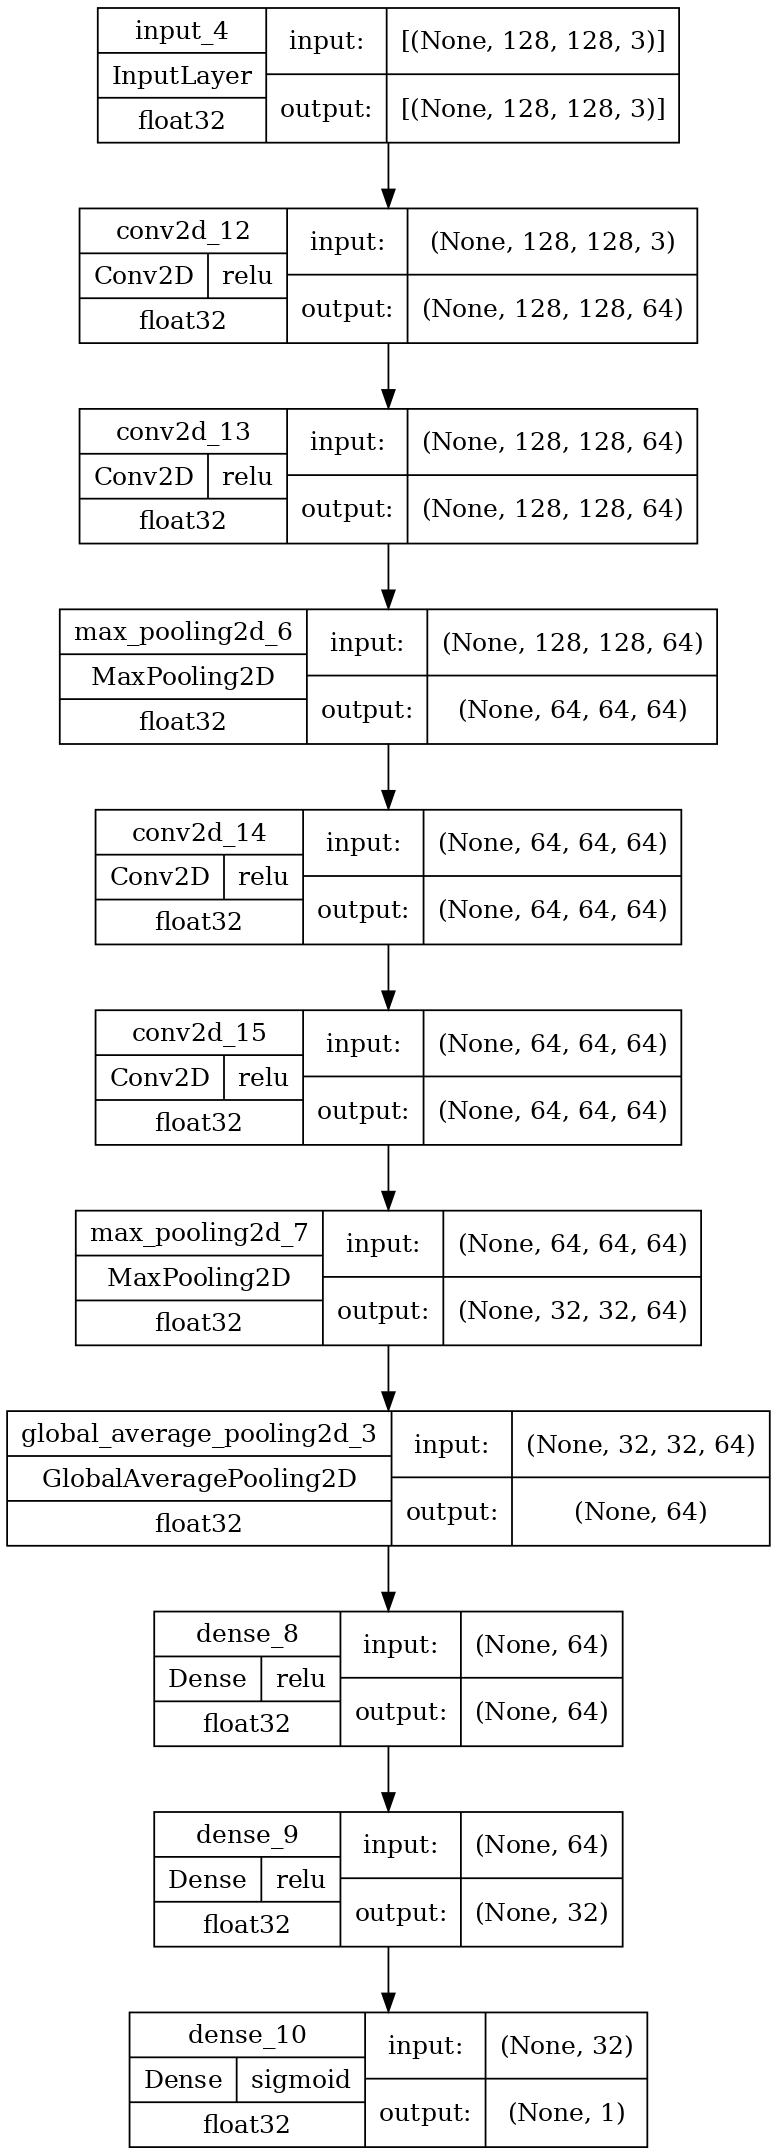

In [55]:
plot_model(model,
           show_shapes=True,
           show_dtype=True,
           show_layer_names= True,
           rankdir=True,
           expand_nested = True,
           show_layer_activations=True,
           dpi=128
          )

In [56]:
model.fit(train_set,
          validation_data=val_set,
          steps_per_epoch=params['steps_per_epoch'],
          validation_steps=params['validation_steps'],
          epochs=params['epochs'],
          batch_size=params['epochs'],
          callbacks=neptune_cbk)

Epoch 1/10
127/127 [==============================] - 10s 70ms/step - loss: 0.6791 - accuracy: 0.5740 - val_loss: 0.6753 - val_accuracy: 0.5718
Epoch 2/10
127/127 [==============================] - 8s 65ms/step - loss: 0.6656 - accuracy: 0.5796 - val_loss: 0.6688 - val_accuracy: 0.5885
Epoch 3/10
127/127 [==============================] - 9s 68ms/step - loss: 0.6586 - accuracy: 0.6119 - val_loss: 0.6742 - val_accuracy: 0.5630
Epoch 4/10
127/127 [==============================] - 8s 66ms/step - loss: 0.6494 - accuracy: 0.6182 - val_loss: 0.6575 - val_accuracy: 0.5963
Epoch 5/10
127/127 [==============================] - 9s 68ms/step - loss: 0.6419 - accuracy: 0.6204 - val_loss: 0.6450 - val_accuracy: 0.6246
Epoch 6/10
127/127 [==============================] - 8s 64ms/step - loss: 0.6294 - accuracy: 0.6532 - val_loss: 0.6321 - val_accuracy: 0.6530
Epoch 7/10
127/127 [==============================] - 8s 64ms/step - loss: 0.5977 - accuracy: 0.6827 - val_loss: 0.6010 - val_accuracy: 0.681

In [57]:
model.save('/kaggle/working/saved_models/mlc-dlws-4.h5')

In [58]:
model_version['model_save/h5_fmt_mlc_dlws_4/'].upload('/kaggle/working/saved_models/mlc-dlws-4.h5')

In [59]:
model_version.stop()
model_init.stop()
project.stop()
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/keval137/ENDW/m/EN-MO22/v/EN-MO22-1/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/keval137/ENDW/m/EN-MO22/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/keval137/ENDW/metadata
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/keval137/ENDW/e/EN-9/metadata
